# Knowledge Graph Building/Classification
Feature set B: (10 features)

Graph Training model: TransE

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.ensemble
import sklearn.svm

import networkx as nx
from networkx import convert_matrix
from sklearn.decomposition import PCA

from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier

import warnings

In [2]:
warnings.filterwarnings('ignore')

## Data Collection

In [3]:
original_data = pd.read_csv(
    "C:/Users/BriGHt/Msc Data Sciences AI and Digital Business/M599/Dataset/DataCoSupplyChain/DataCoSupplyChainDataset.csv",
    encoding='ISO-8859-1')

In [4]:
pd.set_option('display.max_columns', None)
display(original_data.head(10))
print("Number of rows of the dataframe: ", original_data.shape[0])
print("Number of columns of the dataframe: ", original_data.shape[1])

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class
5,TRANSFER,6,4,18.580000,294.980011,Shipping canceled,0,73,Sporting Goods,Tonawanda,EE. UU.,XXXXXXXXX,Kimberly,19488,Flowers,XXXXXXXXX,Consumer,NY,2122 Hazy Corner,14150.0,2,Fitness,43.013969,-78.879066,Pacific Asia,Toowoomba,Australia,19488,1/13/2018 11:03,75935,1360,32.779999,0.10,179250,327.75,0.06,1,327.75,294.980011,18.580000,Oceania,Queensland,CANCELED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/19/2018 11:03,Standard Class
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Constance,19487,Terrell,XXXXXXXXX,Home Office,PR,1879 Green Pine Bank,725.0,2,Fitness,18.242538,-66.037056,Pacific Asia,Guangzhou,China,19487,1/13/2018 10:42,75934,1360,39.330002,0.12,179249,327.75,

Number of rows of the dataframe:  180519
Number of columns of the dataframe:  53


## Onthology

In [5]:
G = nx.DiGraph()

In [6]:
G.add_edge('Order Item Id', 'Days for shipping (real)', label='takes')
G.add_edge('Order Item Id', 'Days for shipment (scheduled)', label='is_scheduled')
G.add_edge('Order Item Id', 'Benefit per order', label='earns')
#G.add_edge('Order Item Id', 'Sales per customer', label='costs')
G.add_edge('Order City', 'Market', label='is_in_market')
#G.add_edge('Latitude', 'Longitude', label='with')
#G.add_edge('Longitude', 'Order City', label='is_located_in')

G.add_edge('Order Item Id', 'Order City', label='is_ordered_from')
#G.add_edge('Order Item Id', 'Order Item Discount Rate', label='has_discount_rate')
G.add_edge('Order Item Id', 'Order Item Quantity', label='has_quantity')

#G.add_edge('Order Item Id', 'Order Status', label='has_order_status')
G.add_edge('Order Item Id', 'Product Card Id', label='has_product_number')
G.add_edge('Product Card Id', 'Product Category Id', label='belongs_to')
G.add_edge('Order Item Id', 'Shipping Mode', label='is_delivered_by')
G.add_edge('Order Item Id', 'Late_delivery_risk', label='has_late_delivery')

#G.add_edge('Sales per customer', 'Order Item Discount', label='causes')
#G.add_edge('Order Item Discount Rate', 'Order Item Discount', label='causes')

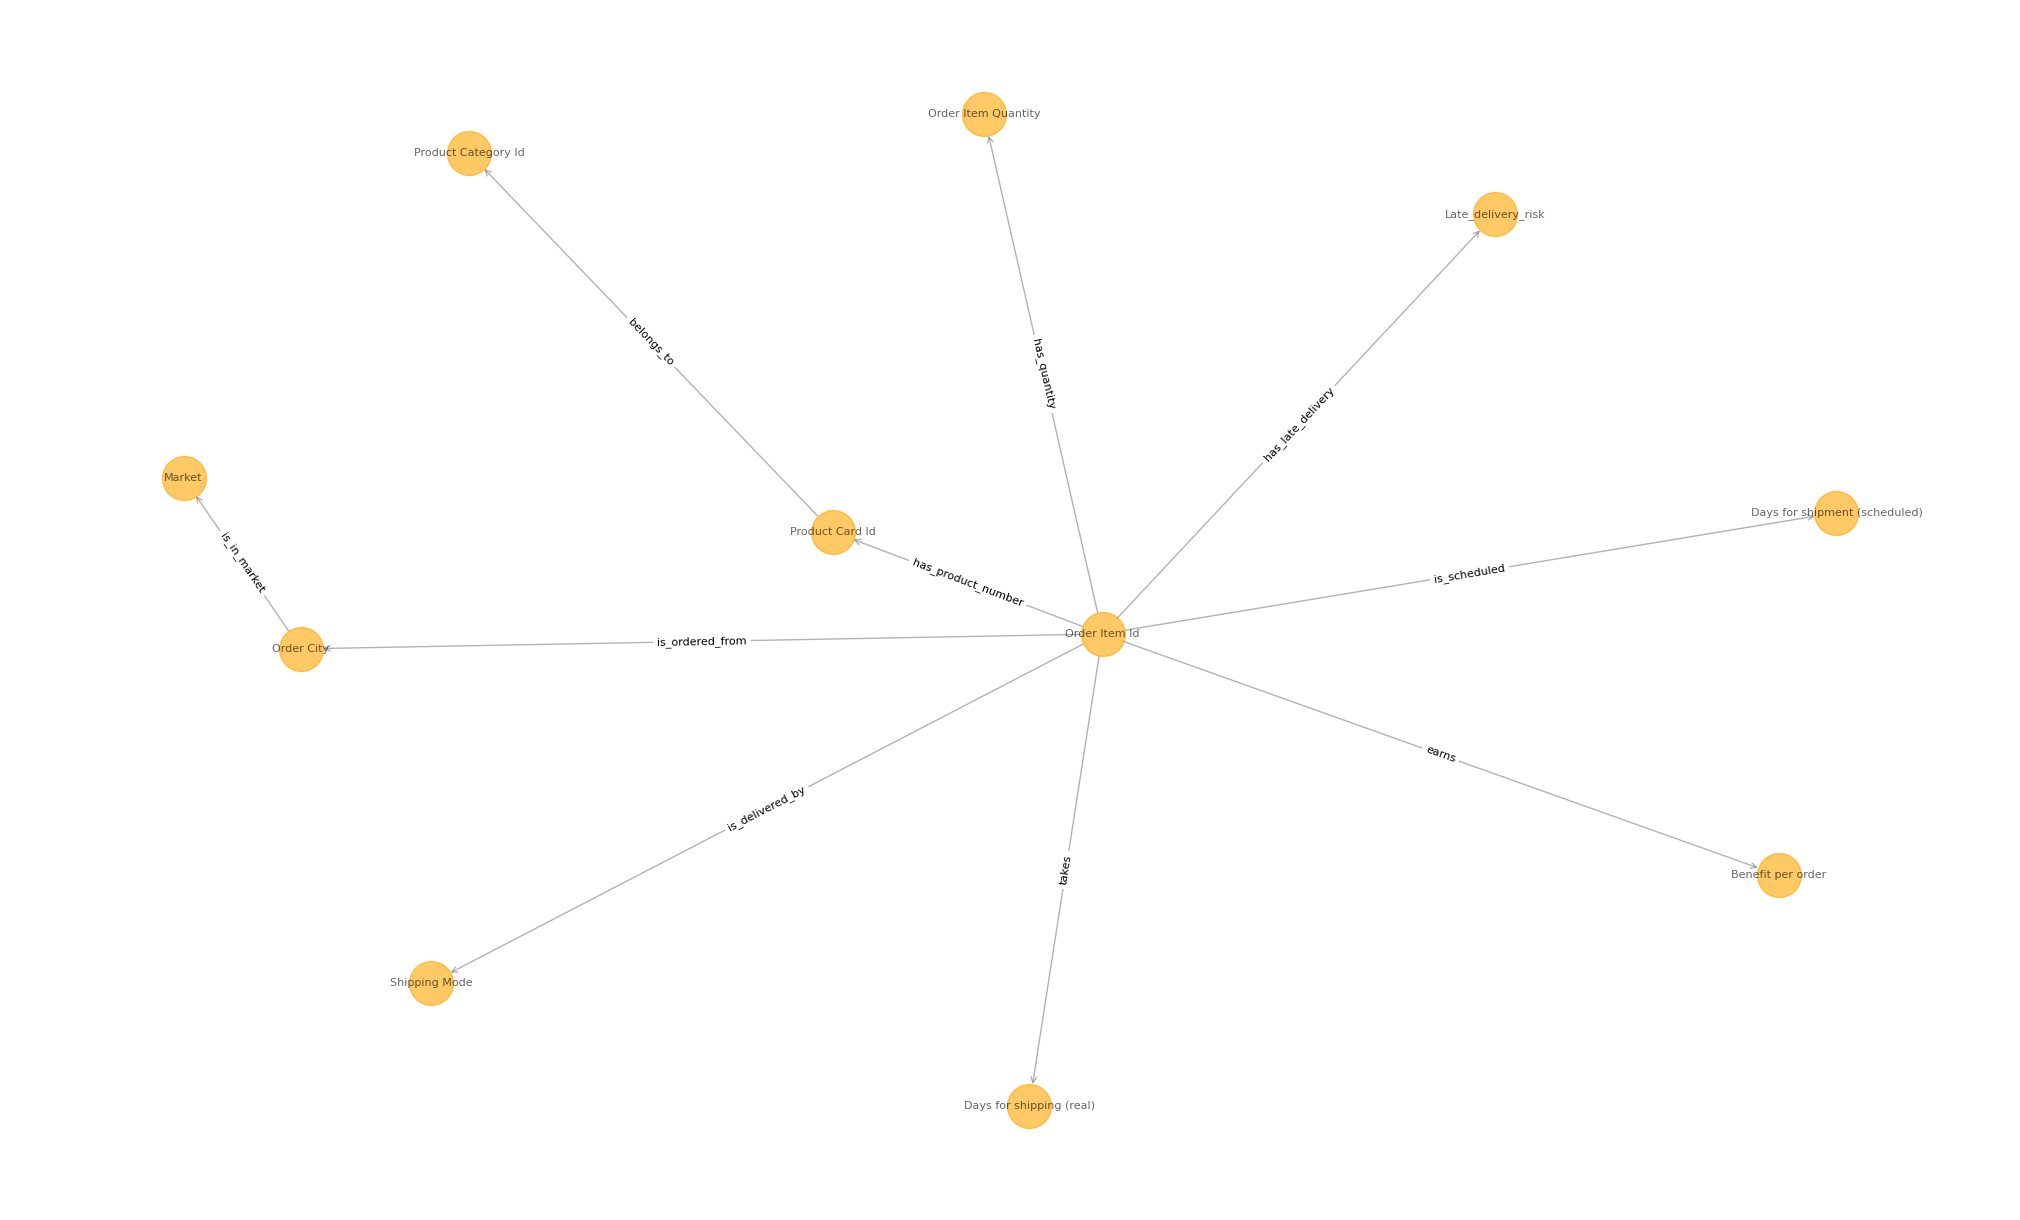

In [7]:
pos = nx.spring_layout(G, seed=30, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(20, 12))
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000, node_color='orange', edge_color='gray', alpha=0.6,
       arrows=True, arrowstyle="->")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

plt.show()

## Splitting and Balancing the Dataset

In [8]:
# Balancing the dataset between positive and negative case.
df_delay = original_data[original_data["Late_delivery_risk"]== 1].head(80000).copy()
df_ontime = original_data[original_data["Late_delivery_risk"]== 0].head(80000).copy()

In [9]:
df_balanced = pd.concat([df_delay, df_ontime], ignore_index=False, sort=False)
df_balanced.sort_index(inplace=True)

## Building a Knowledge Graph

In [10]:
df =df_balanced[["Order Item Id", "Days for shipping (real)", "Days for shipment (scheduled)", "Benefit per order", 
                  "Market", "Order City",
                  "Order Item Quantity", "Product Card Id",
                  "Product Category Id", "Shipping Mode", "Late_delivery_risk"]].copy()

In [11]:
df['Days for shipping (real)'] = df['Days for shipping (real)'].astype(str)
df['Days for shipment (scheduled)'] = df['Days for shipment (scheduled)'].astype(str)
df['Order Item Id'] = df['Order Item Id'].astype(str)
df['Benefit per order'] = df['Benefit per order'].astype(str)
#df['Sales per customer'] = df['Sales per customer'].astype(str)
#df['Latitude'] = df['Latitude'].astype(str)
#df['Longitude'] = df['Longitude'].astype(str)
#df['Order Item Discount'] = df['Order Item Discount'].astype(str)
#df['Order Item Discount Rate'] = df['Order Item Discount Rate'].astype(str)
df['Order Item Quantity'] = df['Order Item Quantity'].astype(str)
df['Product Card Id'] = df['Product Card Id'].astype(str)
df['Product Category Id'] = df['Product Category Id'].astype(str)

df["Late_delivery_risk"] = df['Late_delivery_risk'].apply(lambda x: 'T' if x == 1 else 'F')

The original df is sorted by date/time in ascending order. The idea is to use older data as training set to predict future data.

In [12]:
df_delay_train = df[df["Late_delivery_risk"]== 'T'].head(60000).copy()
df_ontime_train = df[df["Late_delivery_risk"]== 'F'].head(60000).copy()
df_train = pd.concat([df_delay_train, df_ontime_train], ignore_index=False, sort=False)
df_train.sort_index(inplace=True)

In [13]:
df_delay_test = df[df["Late_delivery_risk"]== 'T'].tail(20000).copy()
df_ontime_test = df[df["Late_delivery_risk"]== 'F'].tail(20000).copy()
df_test = pd.concat([df_delay_test, df_ontime_test], ignore_index=False, sort=False)
df_test.sort_index(inplace=True)

In [14]:
G = nx.DiGraph()
for _, row in df.head(10000).iterrows(): 
    G.add_edge(row['Order Item Id'], row['Days for shipping (real)'], label='takes')
    G.add_edge(row['Order Item Id'], row['Days for shipment (scheduled)'], label='is_scheduled')
    G.add_edge(row['Order Item Id'], row['Benefit per order'], label='earns')
    #G.add_edge(row['Order Item Id'], row['Sales per customer'], label='costs') 
    G.add_edge(row['Order City'], row['Market'], label='is_in_market')
    #G.add_edge(row['Latitude'], row['Longitude'], label='with')
    #G.add_edge(row['Longitude'], row['Order City'], label='is_located_in')
    
    G.add_edge(row['Order Item Id'], row['Order City'], label='is_ordered_from')
    #G.add_edge(row['Order Item Id'], row['Order Item Discount Rate'], label='has_discount_rate')
    G.add_edge(row['Order Item Id'], row['Order Item Quantity'], label='has_qty')

    #G.add_edge(row['Order Item Id'], row['Order Status'], label='has_order_status')
    G.add_edge(row['Order Item Id'], row['Product Card Id'], label='has_product_number')
    G.add_edge(row['Product Card Id'], row['Product Category Id'], label='belongs_to')
    G.add_edge(row['Order Item Id'], row['Shipping Mode'], label='is_delivered_by') 
    G.add_edge(row['Order Item Id'], row['Late_delivery_risk'], label='has_late_delivery')

    #G.add_edge(row['Sales per customer'], row['Order Item Discount'], label='causes') 
    #G.add_edge(row['Order Item Discount Rate'], row['Order Item Discount'], label='causes')

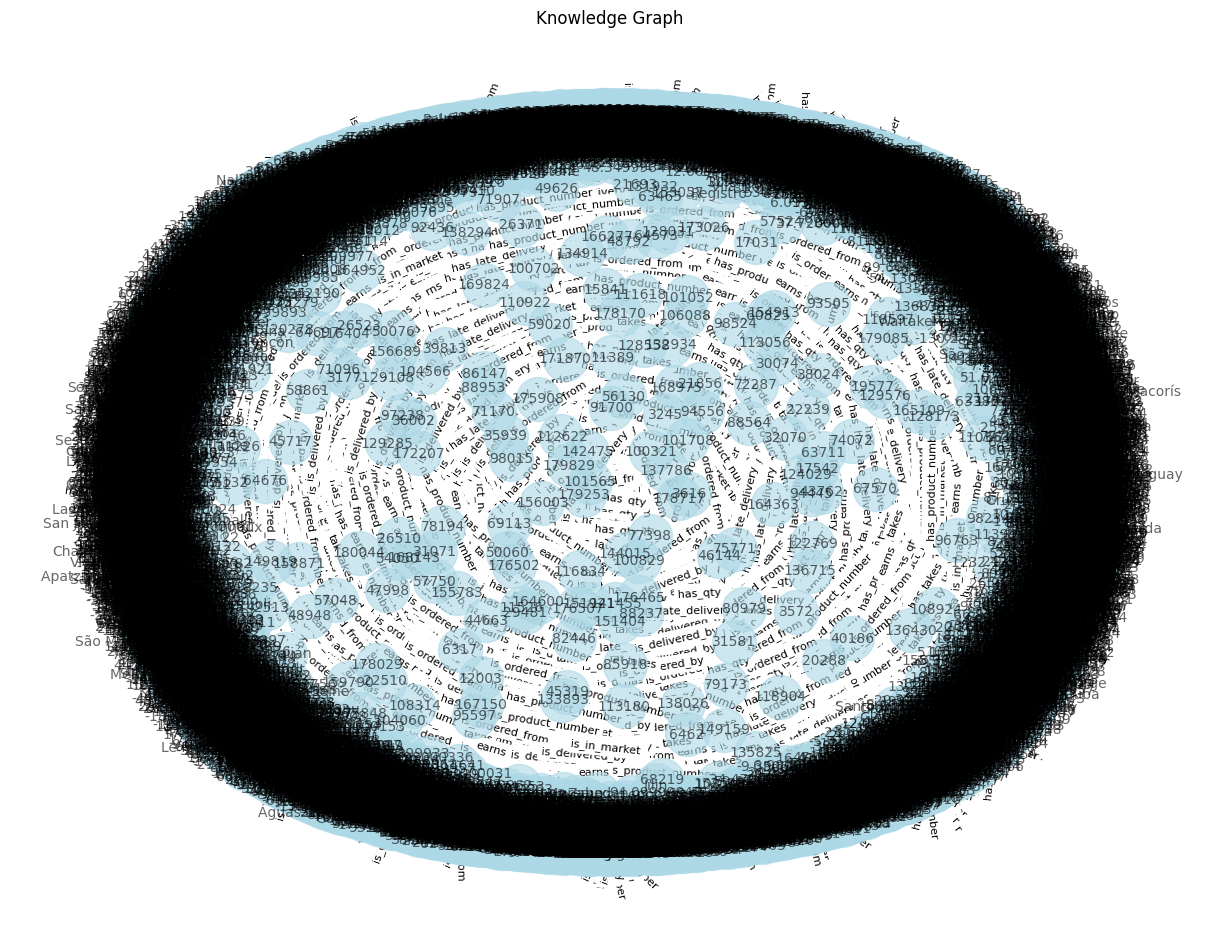

In [25]:
pos = nx.spring_layout(G, seed=30, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 9))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=1000, node_color='lightblue', edge_color='gray', alpha=0.6,
       arrows=True, arrowstyle="->")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

#nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue")
#nx.draw_networkx_edges(G, pos, node_size=1000, arrows=True, arrowstyle="->", arrowsize=10, edge_color='gray', 
#                       edge_cmap=plt.cm.plasma, width=2)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)
#nx.draw_networkx_node_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

plt.title('Knowledge Graph')
plt.show()

## Create Embeddings

In [15]:
# 120000 rows (training set) x 10 relationship per role
X = np.empty((1200000, 3), dtype='<U100')

In [16]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
# Create triples from each row of dataset
for i, row in df_train.iterrows():
    X[i*10] = np.array([[row['Order Item Id'], 'takes', row['Days for shipping (real)']]])
    X[i*10 + 1] = np.array([[row['Order Item Id'], 'is_scheduled', row['Days for shipment (scheduled)']]])
    X[i*10 + 2] = np.array([[row['Order Item Id'], 'earns', row['Benefit per order']]])
    #X[i*16 + 2] = np.array([[row['Order Item Id'], 'costs', row['Sales per customer']]])
    X[i*10 + 3] = np.array([[row['Order City'], 'is_in_market', row['Market']]])
    #X[i*16 + 4] = np.array([[row['Latitude'], 'with', row['Longitude']]])
    #X[i*16 + 5] = np.array([[row['Longitude'], 'is_located_in', row['Order City']]])
    X[i*10 + 4] = np.array([[row['Order Item Id'], 'is_ordered_from', row['Order City']]])
    #X[i*16 + 7] = np.array([[row['Order Item Id'], 'has_discount_rate', row['Order Item Discount Rate']]])
    X[i*10 + 5] = np.array([[row['Order Item Id'], 'has_qty', row['Order Item Quantity']]])
    #X[i*16 + 9] = np.array([[row['Order Item Id'], 'has_order_status', row['Order Status']]])
    X[i*10 + 6] = np.array([[row['Order Item Id'], 'has_product_number', row['Product Card Id']]])
    X[i*10 + 7] = np.array([[row['Product Card Id'], 'belongs_to', row['Product Category Id']]])
    X[i*10 + 8] = np.array([[row['Order Item Id'], 'is_delivered_by', row['Shipping Mode']]])
    X[i*10 + 9] = np.array([[row['Order Item Id'], 'has_late_delivery', row['Late_delivery_risk']]])
    #X[i*16 + 14] = np.array([[row['Sales per customer'], 'causes', row['Order Item Discount']]])
    #X[i*16 + 15] = np.array([[row['Order Item Discount Rate'], 'causes', row['Order Item Discount']]])

X

array([['180517', 'takes', '3'],
       ['180517', 'is_scheduled', '4'],
       ['180517', 'earns', '91.25'],
       ...,
       ['403', 'belongs_to', '18'],
       ['83894', 'is_delivered_by', 'Standard Class'],
       ['83894', 'has_late_delivery', 'F']], dtype='<U100')

In [18]:
X2 = np.empty((360000, 3), dtype='<U100')

In [19]:
for i, row in df_test.iterrows():
    X2[i*9] = np.array([[row['Order Item Id'], 'takes', row['Days for shipping (real)']]])
    X2[i*9 + 1] = np.array([[row['Order Item Id'], 'is_scheduled', row['Days for shipment (scheduled)']]])
    X2[i*9 + 2] = np.array([[row['Order Item Id'], 'earns', row['Benefit per order']]])
    #X2[i*9 + 2] = np.array([[row['Order Item Id'], 'costs', row['Sales per customer']]])
    X2[i*9 + 3] = np.array([[row['Order City'], 'is_in_market', row['Market']]])
    #X2[i*15 + 4] = np.array([[row['Latitude'], 'with', row['Longitude']]])
    #X2[i*15 + 5] = np.array([[row['Longitude'], 'is_located_in', row['Order City']]])
    X2[i*9 + 4] = np.array([[row['Order Item Id'], 'is_ordered_from', row['Order City']]])
    #X2[i*15 + 7] = np.array([[row['Order Item Id'], 'has_discount_rate', row['Order Item Discount Rate']]])
    X2[i*9 + 5] = np.array([[row['Order Item Id'], 'has_qty', row['Order Item Quantity']]])
    #X2[i*15 + 9] = np.array([[row['Order Item Id'], 'has_order_status', row['Order Status']]])
    X2[i*9 + 6] = np.array([[row['Order Item Id'], 'has_product_number', row['Product Card Id']]])
    X2[i*9 + 7] = np.array([[row['Product Card Id'], 'belongs_to', row['Product Category Id']]])
    X2[i*9 + 8] = np.array([[row['Order Item Id'], 'is_delivered_by', row['Shipping Mode']]])
    #X2[i*10 + 9] = np.array([[row['Order Item Id'], 'has_late_delivery', row['Late_delivery_risk']]])
    #X2[i*15 + 13] = np.array([[row['Sales per customer'], 'causes', row['Order Item Discount']]])
    #X2[i*15 + 14] = np.array([[row['Order Item Discount Rate'], 'causes', row['Order Item Discount']]])

X2

array([['146138', 'takes', '2'],
       ['146138', 'is_scheduled', '1'],
       ['146138', 'earns', '28.43000031'],
       ...,
       ['68879', 'has_product_number', '502'],
       ['502', 'belongs_to', '24'],
       ['68879', 'is_delivered_by', 'Standard Class']], dtype='<U100')

In [20]:
X = np.concatenate([X, X2])

In [21]:
X

array([['180517', 'takes', '3'],
       ['180517', 'is_scheduled', '4'],
       ['180517', 'earns', '91.25'],
       ...,
       ['68879', 'has_product_number', '502'],
       ['502', 'belongs_to', '24'],
       ['68879', 'is_delivered_by', 'Standard Class']], dtype='<U100')

In [22]:
X.shape

(1560000, 3)

In [23]:
# Split X to train the embeddings
x_train, x_test = train_test_split_no_unseen(np.array(X), test_size=300000)

In [24]:
print('Train set size: ', x_train.shape)
print('Test set size: ', x_test.shape)

Train set size:  (1260000, 3)
Test set size:  (300000, 3)


In [25]:
model = ScoringBasedEmbeddingModel(k=100, eta=20, scoring_type='TransE', seed=0)

In [26]:
optimizer = Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

model.compile(loss=loss, optimizer=optimizer, entity_relation_regularizer=regularizer, entity_relation_initializer='glorot_uniform')

In [27]:
model.fit(x_train, batch_size=40000, epochs=200, verbose=True)

Epoch 1/200
33/33 [==============================] - 26s 784ms/step - loss: 117670.7891
Epoch 2/200
33/33 [==============================] - 22s 674ms/step - loss: 115313.7812
Epoch 3/200
33/33 [==============================] - 25s 762ms/step - loss: 113150.1484
Epoch 4/200
33/33 [==============================] - 26s 782ms/step - loss: 111138.5078
Epoch 5/200
33/33 [==============================] - 26s 779ms/step - loss: 109256.0469
Epoch 6/200
33/33 [==============================] - 25s 766ms/step - loss: 107489.7812
Epoch 7/200
33/33 [==============================] - 25s 744ms/step - loss: 105831.1406
Epoch 8/200
33/33 [==============================] - 22s 675ms/step - loss: 104274.8047
Epoch 9/200
33/33 [==============================] - 22s 670ms/step - loss: 102812.7344
Epoch 10/200
33/33 [==============================] - 22s 668ms/step - loss: 101438.8281
Epoch 11/200
33/33 [==============================] - 22s 670ms/step - loss: 100146.7812
Epoch 12/200
33/33 [==========

## Evaluating knowledge embeddings

In [28]:
filter = {'test': np.concatenate([x_train, x_test])}

In [29]:
ranks = model.evaluate(x_test, use_filter=filter, corrupt_side='s,o', verbose=True)

30001/30001 [==============================] - 26815s 894ms/step


In [30]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.40
MR: 661.50
Hits@10: 0.49
Hits@3: 0.44
Hits@1: 0.35


## Embedding Visualization

In [31]:
triples_df = pd.DataFrame(X, columns=['s', 'p', 'o'])

In [32]:
nodes_s = triples_df.s.unique()
nodes_o = triples_df.o.unique()

nodes = np.append(nodes_s, nodes_o)
nodes = np.unique(nodes)
len(nodes)

184795

In [33]:
embeddings = dict(zip(nodes, model.get_embeddings(nodes)))
embeddings_array = np.array([i for i in embeddings.values()])

In [34]:
embeddings_array

array([[ 0.06245827,  0.05049516,  0.0353681 , ..., -0.11360283,
         0.11442599, -0.11650038],
       [ 0.14796863,  0.03368568,  0.06012816, ..., -0.15226506,
         0.09946057, -0.10026138],
       [-0.02858876,  0.01631686,  0.06056381, ..., -0.14150564,
         0.13830219, -0.13123749],
       ...,
       [ 0.05183389, -0.00063546,  0.07768269, ..., -0.18099676,
         0.12956107, -0.00968553],
       [ 0.03728568,  0.0539482 ,  0.06692649, ..., -0.12592712,
         0.11380554, -0.07871279],
       [-0.03095624,  0.02333104,  0.09399517, ..., -0.05335094,
         0.11210021, -0.03355268]], dtype=float32)

In [35]:
embeddings_2d = PCA(n_components=2).fit_transform(embeddings_array)

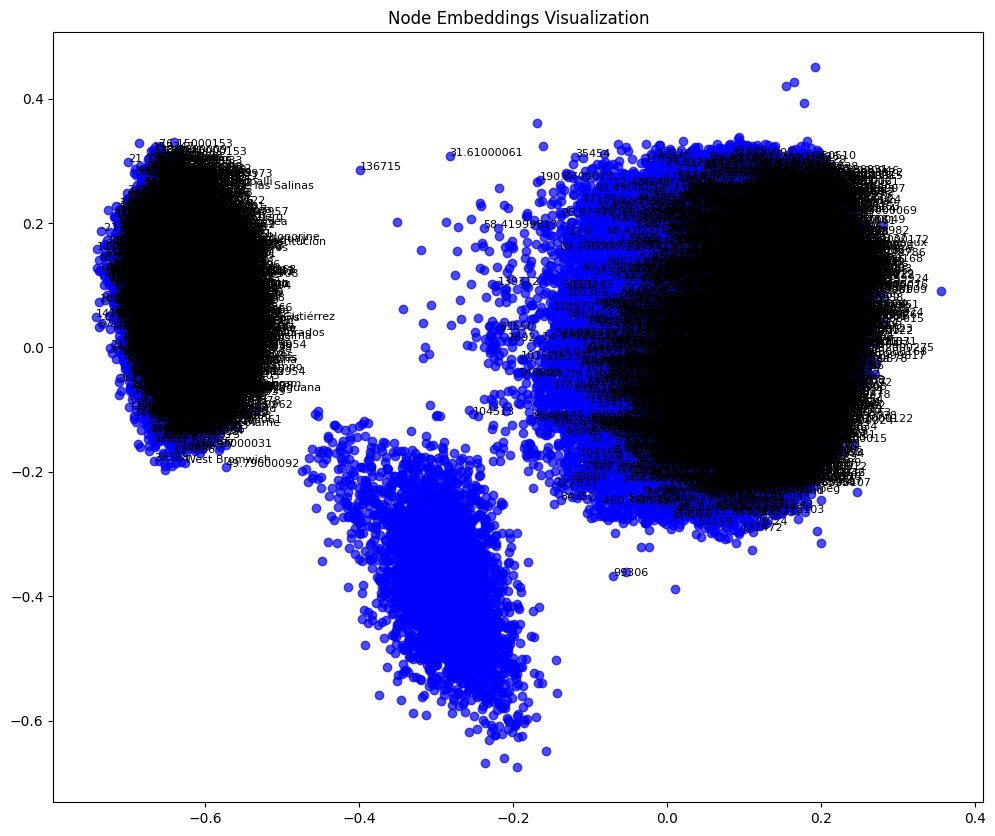

In [36]:
# Visualize embeddings in 2D space with node labels
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)

# Add node labels
for i, node in enumerate(G.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)

plt.title('Node Embeddings Visualization')
plt.show()

## Classification

In [37]:
# Shuffle the dataset
df_train = df_train.sample(frac = 1)
df_test = df_test.sample(frac = 1)

In [38]:
df_train["Late_delivery_risk"].value_counts(normalize=True)

Late_delivery_risk
T    0.5
F    0.5
Name: proportion, dtype: float64

In [39]:
df_test["Late_delivery_risk"].value_counts(normalize=True)

Late_delivery_risk
F    0.5
T    0.5
Name: proportion, dtype: float64

In [40]:
def get_embeddings(node):
    return embeddings.get(node, np.full(100, np.nan))

In [41]:
clf_X_train = np.hstack((np.vstack(df_train["Order Item Id"].apply(get_embeddings).values),
                np.vstack(df_train["Days for shipping (real)"].apply(get_embeddings).values),
                np.vstack(df_train["Days for shipment (scheduled)"].apply(get_embeddings).values),
                np.vstack(df_train["Benefit per order"].apply(get_embeddings).values),
                #np.vstack(df_train["Sales per customer"].apply(get_embeddings).values),
                #np.vstack(df_train["Latitude"].apply(get_embeddings).values),
                #np.vstack(df_train["Longitude"].apply(get_embeddings).values),
                np.vstack(df_train["Market"].apply(get_embeddings).values),
                np.vstack(df_train["Order City"].apply(get_embeddings).values),
                #np.vstack(df_train["Order Item Discount"].apply(get_embeddings).values),
                #np.vstack(df_train["Order Item Discount Rate"].apply(get_embeddings).values),
                np.vstack(df_train["Order Item Quantity"].apply(get_embeddings).values),
                #np.vstack(df_train["Order Status"].apply(get_embeddings).values),
                np.vstack(df_train["Product Card Id"].apply(get_embeddings).values),
                np.vstack(df_train["Product Category Id"].apply(get_embeddings).values),
                np.vstack(df_train["Shipping Mode"].apply(get_embeddings).values)                   
                #np.vstack(x_train["Late_delivery_risk"].apply(get_embeddings).values)
                ))
clf_y_train = df_train.Late_delivery_risk.values

In [42]:
for i in range(0, len(clf_y_train)):
    if clf_y_train[i] == 'T':
        clf_y_train[i] = 1
    else:
        clf_y_train[i] = 0
clf_y_train = clf_y_train.astype('int')

In [43]:
clf_y_train

array([1, 1, 0, ..., 1, 1, 0])

In [44]:
clf_X_test = np.hstack((np.vstack(df_test["Order Item Id"].apply(get_embeddings).values),
                np.vstack(df_test["Days for shipping (real)"].apply(get_embeddings).values),
                np.vstack(df_test["Days for shipment (scheduled)"].apply(get_embeddings).values),
                np.vstack(df_test["Benefit per order"].apply(get_embeddings).values),
                #np.vstack(df_test["Sales per customer"].apply(get_embeddings).values),
                #np.vstack(df_test["Latitude"].apply(get_embeddings).values),
                #np.vstack(df_test["Longitude"].apply(get_embeddings).values),
                np.vstack(df_test["Market"].apply(get_embeddings).values),
                np.vstack(df_test["Order City"].apply(get_embeddings).values),
                #np.vstack(df_test["Order Item Discount"].apply(get_embeddings).values),
                #np.vstack(df_test["Order Item Discount Rate"].apply(get_embeddings).values),
                np.vstack(df_test["Order Item Quantity"].apply(get_embeddings).values),
                #np.vstack(df_test["Order Status"].apply(get_embeddings).values),
                np.vstack(df_test["Product Card Id"].apply(get_embeddings).values),
                np.vstack(df_test["Product Category Id"].apply(get_embeddings).values),
                np.vstack(df_test["Shipping Mode"].apply(get_embeddings).values)                   
                #np.vstack(x_train["Late_delivery_risk"].apply(get_embeddings).values)
                ))
clf_y_test = df_test.Late_delivery_risk.values

In [45]:
for i in range(0, len(clf_y_test)):
    if clf_y_test[i] == 'T':
        clf_y_test[i] = 1
    else:
        clf_y_test[i] = 0
clf_y_test = clf_y_test.astype('int')

In [46]:
clf_y_test

array([0, 1, 0, ..., 0, 1, 1])

In [47]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

0.0

In [48]:
clf_X_test.shape

(40000, 1000)

### XGBoosting

In [49]:
# Use same hyperparameters for every experiment.
xg_model = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=100)

In [50]:
xg_model.fit(clf_X_train, clf_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
xg_predicted = xg_model.predict(clf_X_test)

In [52]:
accuracy = sklearn.metrics.accuracy_score(xg_predicted, clf_y_test)
accuracy

0.960175

In [53]:
precision = sklearn.metrics.precision_score(xg_predicted, clf_y_test)
precision

0.9922

In [54]:
recall = sklearn.metrics.recall_score(xg_predicted, clf_y_test)
recall

0.9324749776796203

In [55]:
f1 = sklearn.metrics.f1_score(xg_predicted, clf_y_test)
f1

0.9614108185363727

## Random Forest

In [95]:
rf_params = {
    "n_estimators": [100],
    "max_depth": [3, 4, 5],
    "criterion": ['gini', 'log_loss', 'entropy']
}

In [56]:
rf_model = sklearn.ensemble.RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=100)

In [57]:
rf_model.fit(clf_X_train, clf_y_train)

RandomForestClassifier(max_depth=4)

In [58]:
rf_predicted = rf_model.predict(clf_X_test)

In [59]:
accuracy2 = sklearn.metrics.accuracy_score(clf_y_test, rf_predicted)
accuracy2

0.964675

In [60]:
precision2 = sklearn.metrics.precision_score(clf_y_test, rf_predicted)
precision2

0.934012048755429

In [61]:
recall2 = sklearn.metrics.recall_score(clf_y_test, rf_predicted)
recall2

1.0

In [62]:
f1_2 = sklearn.metrics.f1_score(clf_y_test, rf_predicted)
f1_2

0.9658802791394007

## Logistic Regression

In [64]:
lr_model = sklearn.linear_model.LogisticRegression(C=2.0, fit_intercept=False, penalty='l2')

In [65]:
lr_model.fit(clf_X_train, clf_y_train)

LogisticRegression(C=2.0, fit_intercept=False)

In [67]:
lr_predicted = lr_model.predict(clf_X_test)

In [68]:
accuracy3 = sklearn.metrics.accuracy_score(clf_y_test, lr_predicted)
accuracy3

0.955475

In [69]:
precision3 = sklearn.metrics.precision_score(clf_y_test, lr_predicted)
precision3

0.9320779775174312

In [70]:
recall3 = sklearn.metrics.recall_score(clf_y_test, lr_predicted)
recall3

0.98255

In [71]:
f1_3 = sklearn.metrics.f1_score(clf_y_test, lr_predicted)
f1_3

0.9566487354866977